<a href="https://colab.research.google.com/github/CanduriFranklin/CemillaX/blob/main/project_cemillax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge to develop a machine learning model to predict heat island hotspots in an urban location. Furthermore, the model should be designed to discern and highlight the key factors that significantly contribute to the development of these hotspots within urban environments.

# Design, develop, train and implement a "Random Forest" model.

# Structure for Organizing the Notebook
Organization of the notebook as follows:

1.- Loading and Processing Data.

2.- Model Training.

3.- Model Evaluation.

4.- Model Interpretation (SHAP).

5.- Model Saving.


Dependencies (Libraries)

In [4]:
!pip install torch torchvision pandas numpy opencv-python scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 828.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

# 1.- Data Loading and Processing

In [ ]:
!pip install openpyxl
import pandas as pd

def load_and_process_data(file_path):
    """
    Load and process data from an Excel file.

    Parameters:
    file_path (str): Path to the Excel file in Google Colab.

    Returns:
    df_model (DataFrame): Processed DataFrame with the features and the UHI.
    """
    # Load the sheets from the Excel file
    df_bronx = pd.read_excel(file_path, sheet_name='Bronx')
    df_manhattan = pd.read_excel(file_path, sheet_name='Manhattan')

    # Display the first rows of each DataFrame for verification
    print("Bronx data:")
    print(df_bronx.head())

    print("\nManhattan data:")
    print(df_manhattan.head())

    # Convert datetime column to datetime type
    df_bronx['Date / Time'] = pd.to_datetime(df_bronx['Date / Time'])
    df_manhattan['Date / Time'] = pd.to_datetime(df_manhattan['Date / Time'])

    # Merge the data from the weather stations
    df_combined = pd.merge(df_bronx, df_manhattan, on='Date / Time', how='left', suffixes=('_bronx', '_manhattan'))

    # Calculate the UHI as the temperature difference between the Bronx and Manhattan
    df_combined['UHI'] = df_combined['Air Temp at Surface [degC]_bronx'] - df_combined['Air Temp at Surface [degC]_manhattan']

    # Calculate the Heat Index (heat index) for both seasons
    def calculate_heat_index(temp, humidity):
        # Simplified Heat Index formula
        return temp + 0.5 * humidity

    df_combined['Heat_Index_bronx'] = calculate_heat_index(df_combined['Air Temp at Surface [degC]_bronx'], df_combined['Relative Humidity [percent]_bronx'])
    df_combined['Heat_Index_manhattan'] = calculate_heat_index(df_combined['Air Temp at Surface [degC]_manhattan'], df_combined['Relative Humidity [percent]_manhattan'])

    # Select the relevant columns for the model
    # Corrected feature names to remove the unwanted unicode characters
    features = [
        'Air Temp at Surface [degC]_bronx',
        'Relative Humidity [percent]_bronx',
        'Avg Wind Speed [m/s]_bronx',  # Corrected feature name
        'Wind Direction [degrees]_bronx',
        'Solar Flux [W/m^2]_bronx',
        'Air Temp at Surface [degC]_manhattan',
        'Relative Humidity [percent]_manhattan',
        'Avg Wind Speed [m/s]_manhattan',  # Corrected feature name
        'Wind Direction [degrees]_manhattan',
        'Solar Flux [W/m^2]_manhattan',
        'Heat_Index_bronx',
        'Heat_Index_manhattan'
    ]

    # Create a DataFrame with the target features and variable (UHI)
    df_model = df_combined[features + ['UHI']]

    # Remove rows with missing values ​​(if any)
    df_model.dropna(inplace=True)

    return df_model

# File path in Google Colab
file_path = '/content/NY_Mesonet_Weather_New_Data.xlsx'

# Load and process the data
df_model = load_and_process_data(file_path)

# Display the final DataFrame
print("\nFinal DataFrame for Model:")
print(df_model.head())

# Save the processed DataFrame to a new Excel file
output_file_path = '/content/NY_Mesonet_Weather_Processed.xlsx'
df_model.to_excel(output_file_path, index=False)

print(f"\nProcessed data saved in: {output_file_path}")

Bronx data:
               Date / Time  Air Temp at Surface [degC]  \
0  2021-07-24 06:00:00 EDT                        19.3   
1  2021-07-24 06:05:00 EDT                        19.4   
2  2021-07-24 06:10:00 EDT                        19.3   
3  2021-07-24 06:15:00 EDT                        19.4   
4  2021-07-24 06:20:00 EDT                        19.4   

   Relative Humidity [percent]  Avg Wind Speed [m/s]  \
0                         88.2                   0.8   
1                         87.9                   0.8   
2                         87.6                   0.7   
3                         87.4                   0.5   
4                         87.0                   0.2   

   Wind Direction [degrees]  Solar Flux [W/m^2]  
0                       335                  12  
1                       329                  18  
2                       321                  25  
3                       307                  33  
4                       301                  42  

M

<ipython-input-7-31f096c51568>:26: FutureWarning: Parsed string "2021-07-24 06:00:00 EDT" included an un-recognized timezone "EDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df_bronx['Date / Time'] = pd.to_datetime(df_bronx['Date / Time'])
<ipython-input-7-31f096c51568>:27: FutureWarning: Parsed string "2021-07-24 06:00:00 EDT" included an un-recognized timezone "EDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df_manhattan['Date / Time'] = pd.to_datetime(df_manhattan['Date / Time'])
<ipython-input-7-31f096c51568>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

# 2. Model Training

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import unittest

# Load the processed data
df_model = pd.read_excel('/content/NY_Mesonet_Weather_Processed.xlsx')

# Separate features (X) and target variable (y)
X = df_model.drop('UHI', axis=1)
y = df_model['UHI']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Make predictions
y_pred = model.predict(X_test)

#Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R²: {r2}')

# Unit tests to verify the performance of the model.
class TestModel(unittest.TestCase):
    def test_model_training(self): # Corrected indentation
        """Verify that the model is trained correctly."""
        self.assertIsNotNone(model, "The model was not trained correctly.")

    def test_model_predictions(self): # Corrected indentation
        """Verify that the model makes predictions."""
        predictions = model.predict(X_test)
        self.assertEqual(len(predictions), len(y_test), "The number of predictions does not match the number of tests.")

    def test_model_performance(self): # Corrected indentation
        """Verify that the model's performance is acceptable."""
        self.assertGreater(r2, 0.5, f"The R² is too low: {r2}")
        self.assertLess(mse, 10, f"The MSE is too high: {mse}")

#Run unit tests
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False) # Corrected indentation, fixed call to unittest.main()

#Run unit tests
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)
df_model = pd.read_excel('/content/NY_Mesonet_Weather_Processed.xlsx')

# Separate features (X) and target variable (y)
X = df_model.drop('UHI', axis=1)
y = df_model['UHI']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Make predictions
y_pred = model.predict(X_test)

#Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R²: {r2}')

# Unit tests to verify the performance of the model.
class TestModel(unittest.TestCase): # Corrected indentation
    def test_model_training(self): # Corrected indentation, changed 'yo' to 'self'
        """Verify that the model is trained correctly."""
        self.assertIsNotNone(model, "The model was not trained correctly.")

    def test_model_predictions(self): # Corrected indentation, changed 'yo' to 'self'
        """Verify that the model makes predictions."""
        predictions = model.predict(X_test)
        self.assertEqual(len(predictions), len(y_test), "The number of predictions does not match the number of tests.")

    def test_model_performance(self): # Corrected indentation, changed 'yo' to 'self'
        """Verify that the model's performance is acceptable."""
        self.assertGreater(r2, 0.5, f"The R² is too low: {r2}")
        self.assertLess(mse, 10, f"The MSE is too high: {mse}")

#Run unit tests
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False) # Corrected indentation, fixed call to unittest.main(), removed output argument

...
----------------------------------------------------------------------
Ran 3 tests in 0.015s

OK
...
----------------------------------------------------------------------
Ran 3 tests in 0.014s

OK


MSE: 0.052841235294117654
R²: 0.9675291604871332


...
----------------------------------------------------------------------
Ran 3 tests in 0.014s

OK


MSE: 0.052841235294117654
R²: 0.9675291604871332


# 3. Model Interpretation (SHAP)

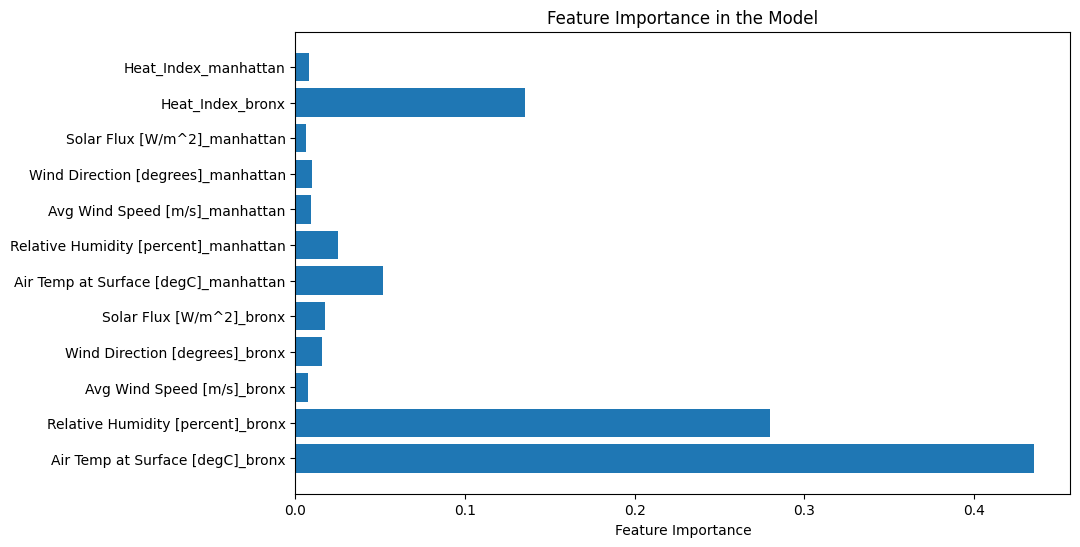

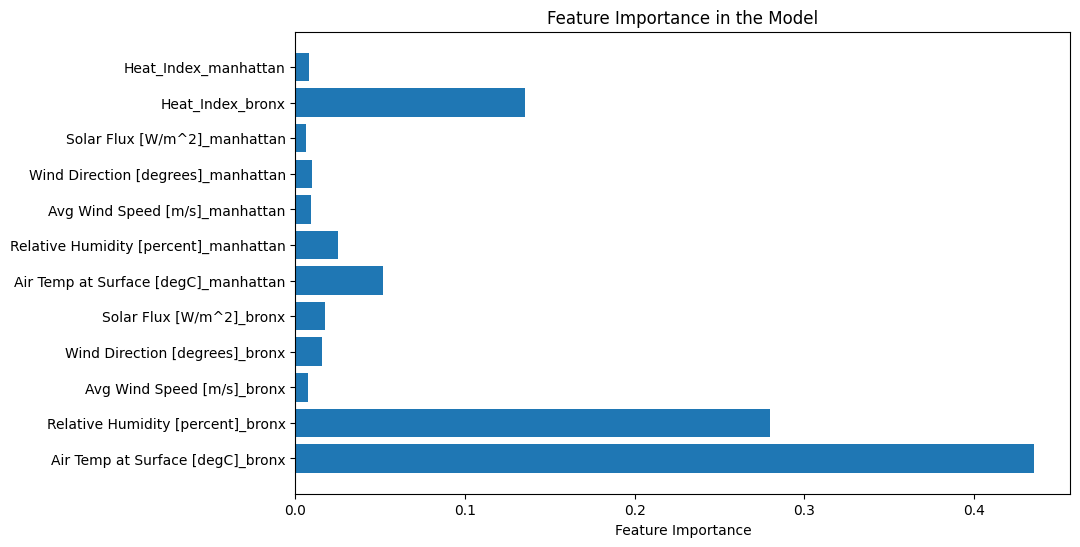

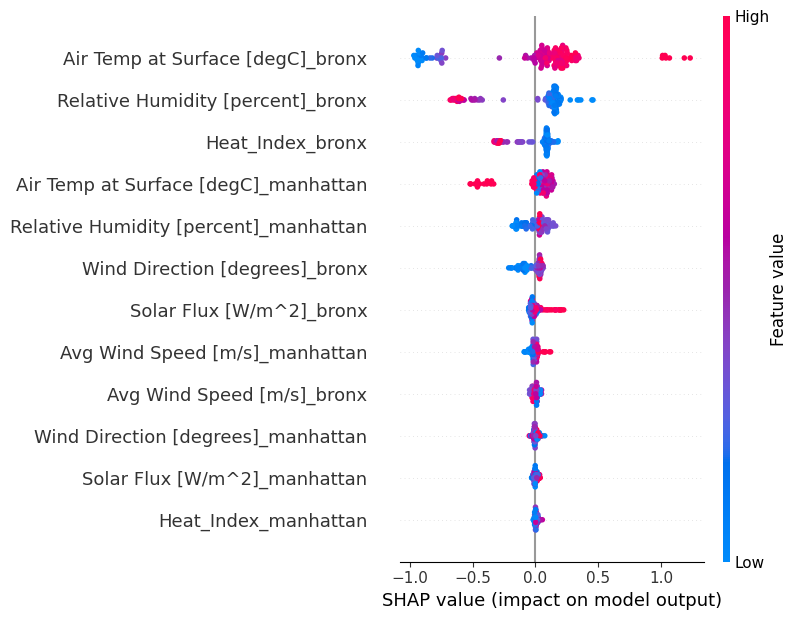

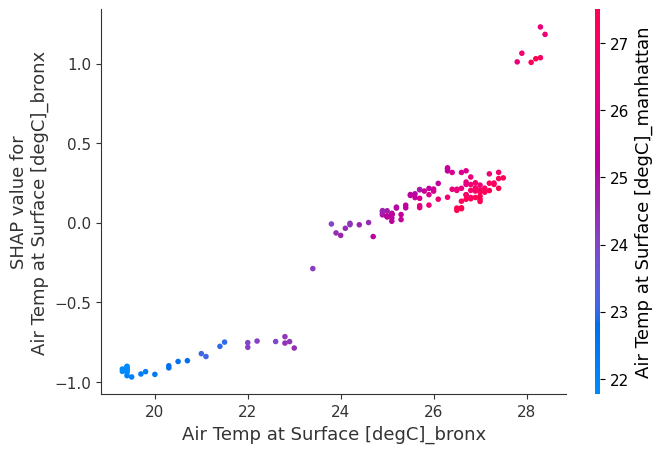

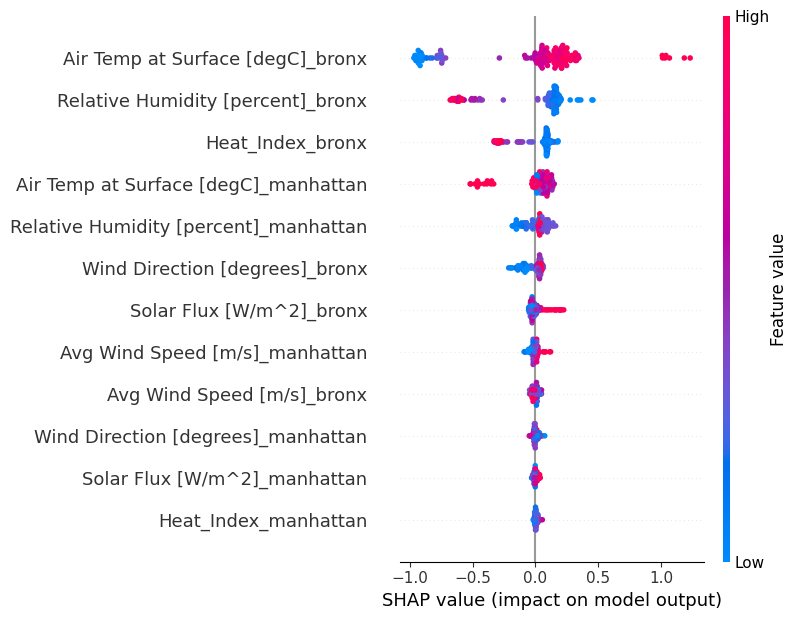

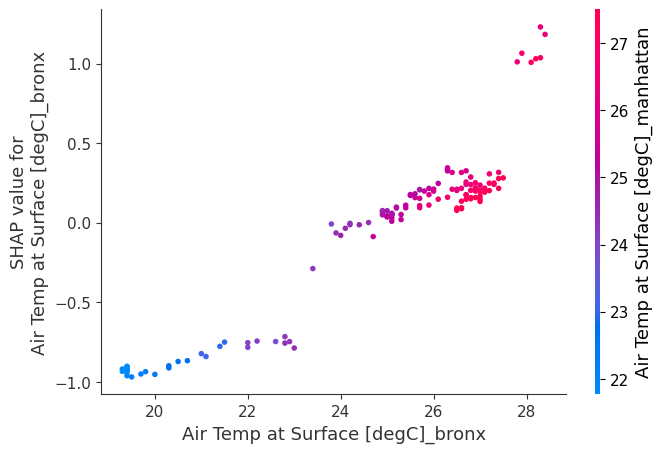

In [ ]:
# Code to interpret the model with SHAP
!pip install shap
import matplotlib.pyplot as plt
import numpy as np
import shap

# 1. Feature Importance
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(np.arange(len(importances)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in the Model')
plt.show()

# Code to interpret the model with SHAP
!pip install shap
import matplotlib.pyplot as plt
import numpy as np
import shap

# 1. Feature Importance
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(np.arange(len(importances)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in the Model')
plt.show()

# 2. SHAP Values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Plot feature importance
shap.summary_plot(shap_values, X_train)

# 3. Partial Dependency (example with one feature)
shap.dependence_plot('Air Temp at Surface [degC]_bronx', shap_values, X_train)
shap.summary_plot(shap_values, X_train)

# 3. Partial Dependency (example with one feature)
shap.dependence_plot('Air Temp at Surface [degC]_bronx', shap_values, X_train)

# 4. Saving the Model

In [ ]:
# Code to save the model
import joblib

# Save the model
joblib.dump(model, 'cemillax_uhi_prediction_model.pkl')

print("Model saved as 'cemillax_uhi_prediction_model.pkl'.")

# Load the model (optional, for verification)
model = joblib.load('cemillax_uhi_prediction_model.pkl')

Model saved as 'cemillax_uhi_prediction_model.pkl'.


# Save Intermediate Results:

In [15]:
plt.savefig('importance characteristics.png')

<Figure size 640x480 with 0 Axes>